In [1]:
import time 
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import NumRadicalElectrons

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import Stoned

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [3]:
smi_dict = pickle.load(open("Mol_list_to_mutate.pkl",'rb'))
parent_mol_names = [key for key in smi_dict.keys()]
#smi -> mol
mols = [Chem.MolFromSmiles(smi) for smi in smi_dict.values()]
legends = [name for name in smi_dict.keys()]
img=Draw.MolsToGridImage(mols,molsPerRow=3,legends=legends)
img

In [4]:
the_data = pickle.load(open("the_data_NEW_2.pkl",'rb'))
parent_data = pickle.load(open("parent_data.pkl",'rb'))

In [5]:
pd.DataFrame(the_data)

Family    Mol_names  fp_scores  \
0      PXZ-TRZ    PXZ-TRZ_1   0.714286   
1      PXZ-TRZ    PXZ-TRZ_2   0.393939   
2      PXZ-TRZ    PXZ-TRZ_3   0.477707   
3      PXZ-TRZ    PXZ-TRZ_4   0.234973   
4      PXZ-TRZ    PXZ-TRZ_5   0.445161   
...        ...          ...        ...   
17497   YAFNOI  YAFNOI_1921   0.551020   
17498   YAFNOI  YAFNOI_1922   0.403846   
17499   YAFNOI  YAFNOI_1923   0.416667   
17500   YAFNOI  YAFNOI_1924   0.416667   
17501   YAFNOI  YAFNOI_1925   0.401869   

                                                  SMILES  N_atoms shell_type  \
0      C1=CPC2C(=C1)Oc1ccccc1N2c1ccc(-c2nc(-c3ccccc3)...       38     closed   
1      FC=CC(=CC=CC1C=C2C=CSC(=C2)C=NC(c2ccccc2)=N1)N...       39     closed   
2      C=Cc1ccsc1CN=NC(=NC(=N)c1ccc(N2c3ccccc3Oc3cccc...       40     closed   
3      NC1=CC=CCC(C=CC=CCBr)(N=CC2=CC=CC=CS2)c2ccccc2...       38     closed   
4      CCN=CC1C=CC=CN=C(c2ccc(N3c4ccccc4Oc4ccccc43)cc...       37     closed   
...                                                  ...      ...        ...   
17497        C=C1C=C2c3ccccc3S3(c4ccccc4-c4ccccc43)C2OC1       26     closed   
17498           C=CC1=CC1c1ccccc1[SH]1c2ccccc2-c2ccccc21       24     closed   
17499      C1=CSC(=Cc2ccccc2[SH]2c3ccccc3-c3ccccc32)C=C1       26     closed   
17500  C1=CC(=Cc2ccccc2)C([SH]2c3ccccc3-c3ccccc32)=C[...       26     closed   
17501      C1=CC=CC=CS2(C=CC=CC[O+]=1)c1ccccc1-c1ccccc12       25     closed   

             SYBA  
0      -46.560050  
1     -114.606299  
2       -2.852969  
3     -182.156780  
4     -122.860454  
...           ...  
17497  -30.960460  
17498  -34.616466  
17499  -46.327961  
17500   -9.460602  
17501  -32.985463  

[17502 rows x 7 columns]

# FF optmise

In [6]:
the_data['filter4'] = []
   
for i,smi in enumerate(the_data['Mol_names']):
    fam = the_data['Family'][i]
    parent_natom_thresh = pd.DataFrame(parent_data).query('molecule == @fam')['n_atoms'].values[0] - 10
    if the_data['N_atoms'][i] >= (parent_natom_thresh) and the_data['SYBA'][i] >= -20:# and the_data['shell_type'][i] == 'closed':
        the_data['filter4'].append('Pass')
    else:
        the_data['filter4'].append('Fail')

`rdkit.Chem.rdForceFieldHelpers.MMFFOptimizeMolecule((Mol)mol[, (str)mmffVariant='MMFF94'[, (int)maxIters=200[, (float)nonBondedThresh=100.0[, (int)confId=-1[, (bool)ignoreInterfragInteractions=True]]]]])` → int :
uses MMFF to optimize a molecule’s structure

ARGUMENTS:

`mol` : the molecule of interest

`mmffVariant` : “MMFF94” or “MMFF94s”

`maxIters` : the maximum number of iterations (defaults to 200)

`nonBondedThresh` : used to exclude long-range non-bonded
interactions (defaults to 100.0)

`confId` : indicates which conformer to optimize

`ignoreInterfragInteractions`: if true, nonbonded terms between
fragments will not be added to the forcefield

RETURNS: 0 if the optimization converged, -1 if the forcefield could
not be set up, 1 if more iterations are required.

### This takes time

In [7]:
the_data['FF_geopt'] = []
for i,smi in enumerate(the_data['SMILES']):
    
    if the_data['filter4'][i] == 'Pass':
        
        mol = Chem.MolFromSmiles(smi)
        mol_H = AllChem.AddHs(mol)
        try:
            AllChem.EmbedMolecule(mol_H)
        except Exception as e:
            print('EmbedMolecule error:',e)
        try:
            geopt = AllChem.MMFFOptimizeMolecule(mol_H)
            print(geopt)
            if geopt == 0:
                print('Geometry optimisation success:', the_data['Mol_names'][i])
                the_data['FF_geopt'].append(0)
            elif geopt == 1:
                print('Geometry optimisation unsuccessful (1) need more iter:', the_data['Mol_names'][i])
                the_data['FF_geopt'].append(1)
            else:
                print('Geometry optimisation unsuccessful (-1):', the_data['Mol_names'][i])
                the_data['FF_geopt'].append(-1)

        except Exception as e:
            print('MMFFOptimizeMolecule error:',e)
            the_data['FF_geopt'].append(float('nan'))
    elif the_data['filter4'][i] == 'Fail':
        the_data['FF_geopt'].append(float('nan'))

parent_data

In [14]:
pickle.dump(the_data,open("the_data_TEMP.pkl",'wb'))
the_data_TEMP = pickle.load(open("the_data_TEMP.pkl",'rb'))
pd.DataFrame(the_data_TEMP).query("filter4=='Fail'")['SMILES'][5]#.dropna()

'C=Cc1ccsc1C#[P+]=NC(=NC(=N)c1ccc(N2c3ccccc3Oc3ccccc32)cc1)c1ccccc1'

# Need to convert to XYZ OR PDT

In [25]:
the_data_NEW_3 = pickle.load(open("the_data_NEW_3.pkl",'rb'))

shows the same molecule so its no problem merging the data

24
PXZ-TRZ


['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3769, 3484, 2725, 897, 24]
273
TXO-PhCz


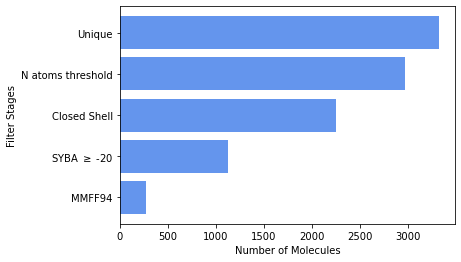

['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3325, 2971, 2257, 1123, 273]
43
TXO-TPA


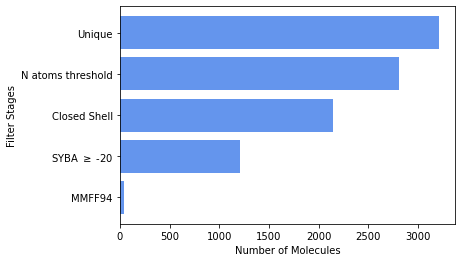

['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3210, 2814, 2147, 1209, 43]
111
GOBVUP


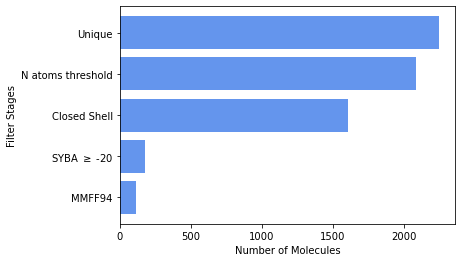

['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [2247, 2087, 1610, 177, 111]
166
TUFWAS


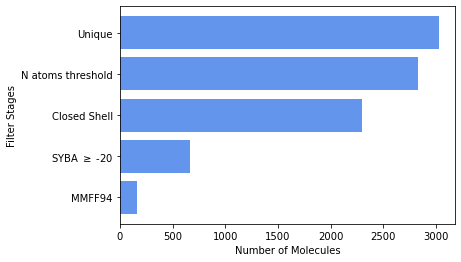

['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3026, 2831, 2298, 666, 166]
516
YAFNOI


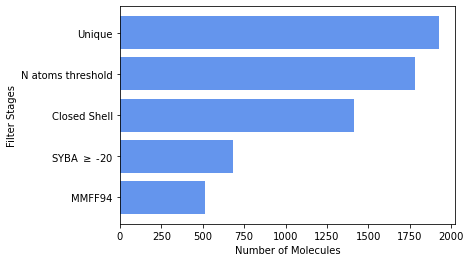

['Unique', 'N atoms threshold', 'Closed Shell', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [1925, 1784, 1410, 685, 516]


In [10]:
img_dpi  = 300
df = pd.DataFrame(the_data_NEW_3)
for i,fam in enumerate(parent_data['molecule']):
    
    thresh = parent_data['n_atoms'][i] - 10
    N_unique_mols = df.query("Family == @fam").shape[0]
    N_atoms = df.query("Family == @fam").query("N_atoms >= @thresh").shape[0]
    N_closed = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").shape[0]
    N_syba = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').shape[0]
    N_FFopt = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').query('FF_optimisation_msg == "0"').shape[0]
    print(N_FFopt)
    x = [0,-1,-2,-3,-4]
    y = [N_unique_mols,N_atoms, N_closed, N_syba,N_FFopt]
    y_ticks_labels = ['Unique','N atoms threshold','Closed Shell','SYBA $\geq$ -20','MMFF94']
    
    
    
    plt.barh(x,y,color='cornflowerblue')
    plt.yticks(x,y_ticks_labels)
    plt.xlabel("Number of Molecules")
    plt.ylabel("Filter Stages")
#     plt.title(fam)
    print(fam)
    plt.savefig('Images/Funnel_Barh_'+fam+'_FILTERED.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print(y_ticks_labels, '\n',y)

37
PXZ-TRZ


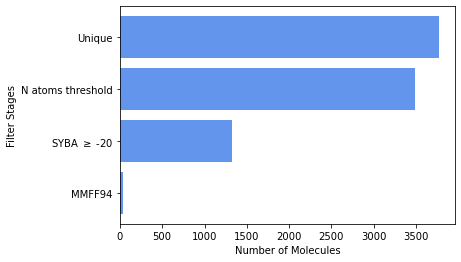

['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3769, 3484, 1321, 37]
397
TXO-PhCz


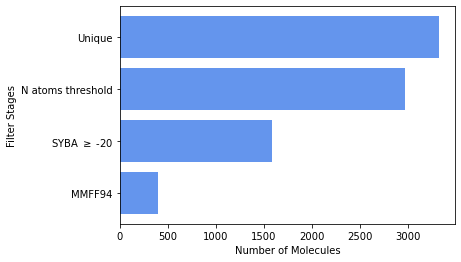

['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3325, 2971, 1581, 397]
72
TXO-TPA


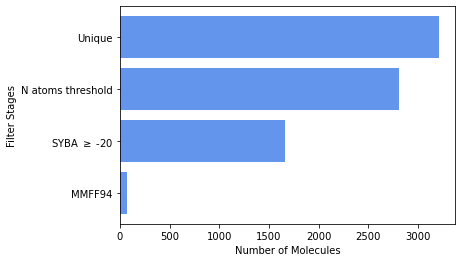

['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3210, 2814, 1660, 72]
170
GOBVUP


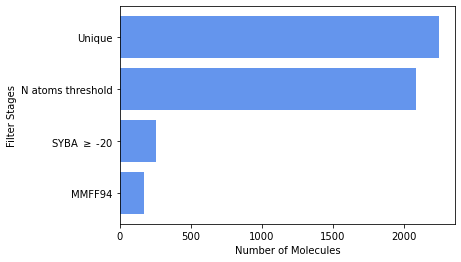

['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [2247, 2087, 257, 170]
204
TUFWAS


['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [3026, 2831, 853, 204]
707
YAFNOI


['Unique', 'N atoms threshold', 'SYBA $\\geq$ -20', 'MMFF94'] 
 [1925, 1784, 958, 707]


In [26]:
img_dpi  = 300
df = pd.DataFrame(the_data_NEW_3)
for i,fam in enumerate(parent_data['molecule']):
    
    thresh = parent_data['n_atoms'][i] - 10
    N_unique_mols = df.query("Family == @fam").shape[0]
    N_atoms = df.query("Family == @fam").query("N_atoms >= @thresh").shape[0]
    N_syba = df.query("Family == @fam").query("N_atoms >= @thresh").query('SYBA >= -20').shape[0]
    N_FFopt = df.query("Family == @fam").query("N_atoms >= @thresh").query('SYBA >= -20').query('FF_optimisation_msg == "0"').shape[0]
    print(N_FFopt)
    x = [0,-1,-2,-3]
    y = [N_unique_mols,N_atoms, N_syba,N_FFopt]
    y_ticks_labels = ['Unique','N atoms threshold','SYBA $\geq$ -20','MMFF94']
    
    
    
    plt.barh(x,y,color='cornflowerblue')
    plt.yticks(x,y_ticks_labels)
    plt.xlabel("Number of Molecules")
    plt.ylabel("Filter Stages")
#     plt.title(fam)
    print(fam)
    plt.savefig('Images/Funnel_Barh_'+fam+'_FILTERED.png', bbox_inches='tight',dpi=img_dpi)
    plt.show()
    print(y_ticks_labels, '\n',y)

In [11]:
for i,fam in enumerate(parent_data['molecule']):
    
    thresh = parent_data['n_atoms'][i] - 10
    N_unique_mols = df.query("Family == @fam").shape[0]
    N_atoms = df.query("Family == @fam").query("N_atoms >= @thresh").shape[0]
    N_closed = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").shape[0]
    N_syba = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').shape[0]
    N_FFopt = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').query('FF_optimisation_msg == "0"').shape[0]
    print(fam)
    y = [N_unique_mols,N_atoms, N_closed, N_syba,N_FFopt]
    y_ticks_labels = ['Unique','N atoms threshold','Closed Shell','SYBA $\geq$ -20','MMFF94']
    
    table = pd.DataFrame({'Filter Stages':y_ticks_labels,'Number of Molecules':y})
    display(table[['Number of Molecules']])

PXZ-TRZ


Number of Molecules
0                 3769
1                 3484
2                 2725
3                  897
4                   24

TXO-PhCz


Number of Molecules
0                 3325
1                 2971
2                 2257
3                 1123
4                  273

TXO-TPA


Number of Molecules
0                 3210
1                 2814
2                 2147
3                 1209
4                   43

GOBVUP


Number of Molecules
0                 2247
1                 2087
2                 1610
3                  177
4                  111

TUFWAS


Number of Molecules
0                 3026
1                 2831
2                 2298
3                  666
4                  166

YAFNOI


Number of Molecules
0                 1925
1                 1784
2                 1410
3                  685
4                  516

In [14]:
all_smi_data = pickle.load(open("all_smi_data.pkl",'rb'))

24
272
43
110
165
515


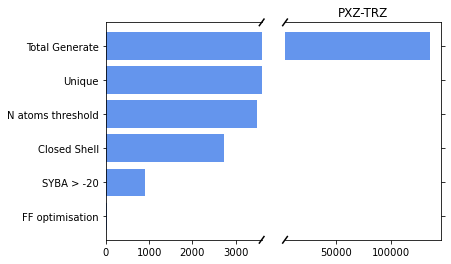

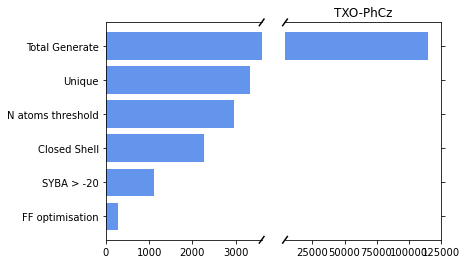

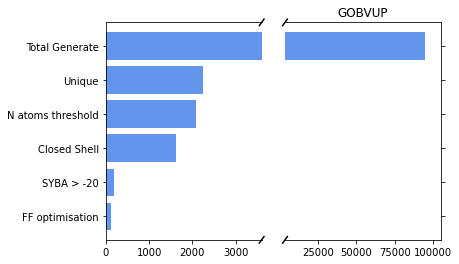

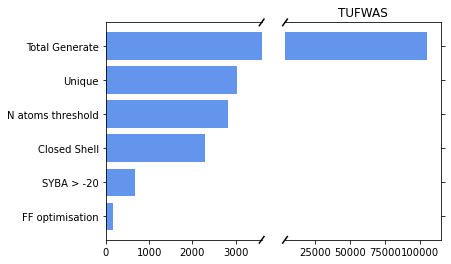

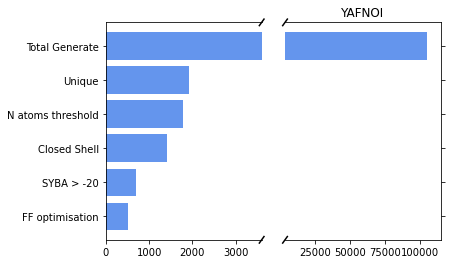

In [15]:
for i,fam in enumerate(parent_data['molecule']):
    
    
    fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
    color = 'cornflowerblue'

    tot_gen = len(all_smi_data[fam])
    
    df = pd.DataFrame(the_data_NEW_3).query('Family == @fam').query("fp_scores != 1")
    unique_smi = df.shape[0]
    
    thresh = parent_data['n_atoms'][i] - 10
    f1 = df.query("N_atoms >= @thresh").shape[0]
    
    
    f2 = df.query("N_atoms >= @thresh").query("shell_type == 'closed'").shape[0]
    f3 = df.query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').shape[0]
    f4 = df.query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').query('FF_optimisation_msg == "0"').shape[0]

    x = [0,-1,-2,-3,-4,-5]
    y = [tot_gen,unique_smi, f1, f2, f3,f4]
    print(f4)

    ax1.barh(x,y,color=color)
    ax2.barh(x,y,color=color)
    
    ax1.set_xlim(0,3600) # most of the data
    ax2.set_xlim(3600,max(y)+10000) # outliers only
    
    # hide the spines between ax and ax2
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
#     ax1.tick_params(labeltop='off') # don't put tick labels at the top 
    ax2.yaxis.tick_right()
    
    # Make the spacing between the two axes a bit smaller
    plt.subplots_adjust(wspace=0.15)
    
    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
    ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal

    ax1.set_yticks(x)
    ax1.set_yticklabels(['Total Generate','Unique','N atoms threshold','Closed Shell','SYBA > -20','FF optimisation'])
    
    plt.title(fam)
plt.show()

# Summary

In [16]:
for i,fam in enumerate(parent_data['molecule']):
    df = pd.DataFrame(the_data_NEW_3).query('Family == @fam').query("fp_scores != 1")
    
    thresh = parent_data['n_atoms'][i] - 10
    tot_gen = len(all_smi_data[fam])
    N_unique_mols = df.query("Family == @fam").shape[0]
    N_atoms = df.query("Family == @fam").query("N_atoms >= @thresh").shape[0]
    N_closed = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").shape[0]
    N_syba = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').shape[0]
    N_FFopt = df.query("Family == @fam").query("N_atoms >= @thresh").query("shell_type == 'closed'").query('SYBA >= -20').query('FF_optimisation_msg == "0"').shape[0]
    print(fam)
    y = [tot_gen,N_unique_mols,N_atoms, N_closed, N_syba,N_FFopt]
    y_ticks_labels = ['Total Generated SMILES','Unique SMILES','N atoms threshold','Closed Shell','SYBA $\geq$ -20','MMFF94']
    
    table = pd.DataFrame({'Filter Stages':y_ticks_labels,'Number of Molecules':y})
    display(table[['Number of Molecules']])

PXZ-TRZ


Number of Molecules
0               135000
1                 3768
2                 3483
3                 2724
4                  896
5                   24

TXO-PhCz


Number of Molecules
0               115000
1                 3324
2                 2970
3                 2256
4                 1122
5                  272

TXO-TPA


Number of Molecules
0               135000
1                 3209
2                 2813
3                 2146
4                 1208
5                   43

GOBVUP


Number of Molecules
0                95000
1                 2246
2                 2086
3                 1609
4                  176
5                  110

TUFWAS


Number of Molecules
0               105000
1                 3025
2                 2830
3                 2297
4                  665
5                  165

YAFNOI


Number of Molecules
0               105000
1                 1924
2                 1783
3                 1409
4                  684
5                  515